In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import statistics
import rasterio
import geopandas as gpd
from shapely.geometry import Point, Polygon, GeometryCollection, Polygon, mapping

In [112]:
database1 = pd.read_csv("/Users/rishi/Documents/ORNL Internships/25/Data/CSVs/Database_p1.csv", encoding='latin1')
database2 = pd.read_csv("/Users/rishi/Documents/ORNL Internships/25/Data/CSVs/Database_p2.csv", encoding='latin1')
database3 = pd.read_csv("/Users/rishi/Documents/ORNL Internships/25/Data/CSVs/Database_p3.csv", encoding='latin1')
biomes = pd.read_csv("/Users/rishi/Documents/ORNL Internships/25/Data/Spatial/Olsen_Biome/Biomes.csv")
kumar_processed = pd.read_csv("/Users/rishi/Documents/ORNL Internships/25/Data/CSVs/kumarathunge_processed.csv")
shape = gpd.read_file("/Users/rishi/Documents/ORNL Internships/25/Data/Spatial/Olsen_Biome/official/wwf_terr_ecos.shp")

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (1,29,30,39,42,43) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (1,29,30,33,35,43,44) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (29,43,44) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [115]:
database = pd.concat([database1,database2,database3],ignore_index=True)

Biome = []

for i in range(len(kumar_processed)):
    pt = Point(kumar_processed['Longitude'][i], kumar_processed['Latitude'][i])
    Biome.append(shape.loc[shape['geometry'].contains(pt), 'BIOME'].values[0])

kumar_processed['Biome_number'] = Biome

database = pd.concat([database,kumar_processed],ignore_index=True)

database = pd.merge(database,biomes,on='Biome_number')

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


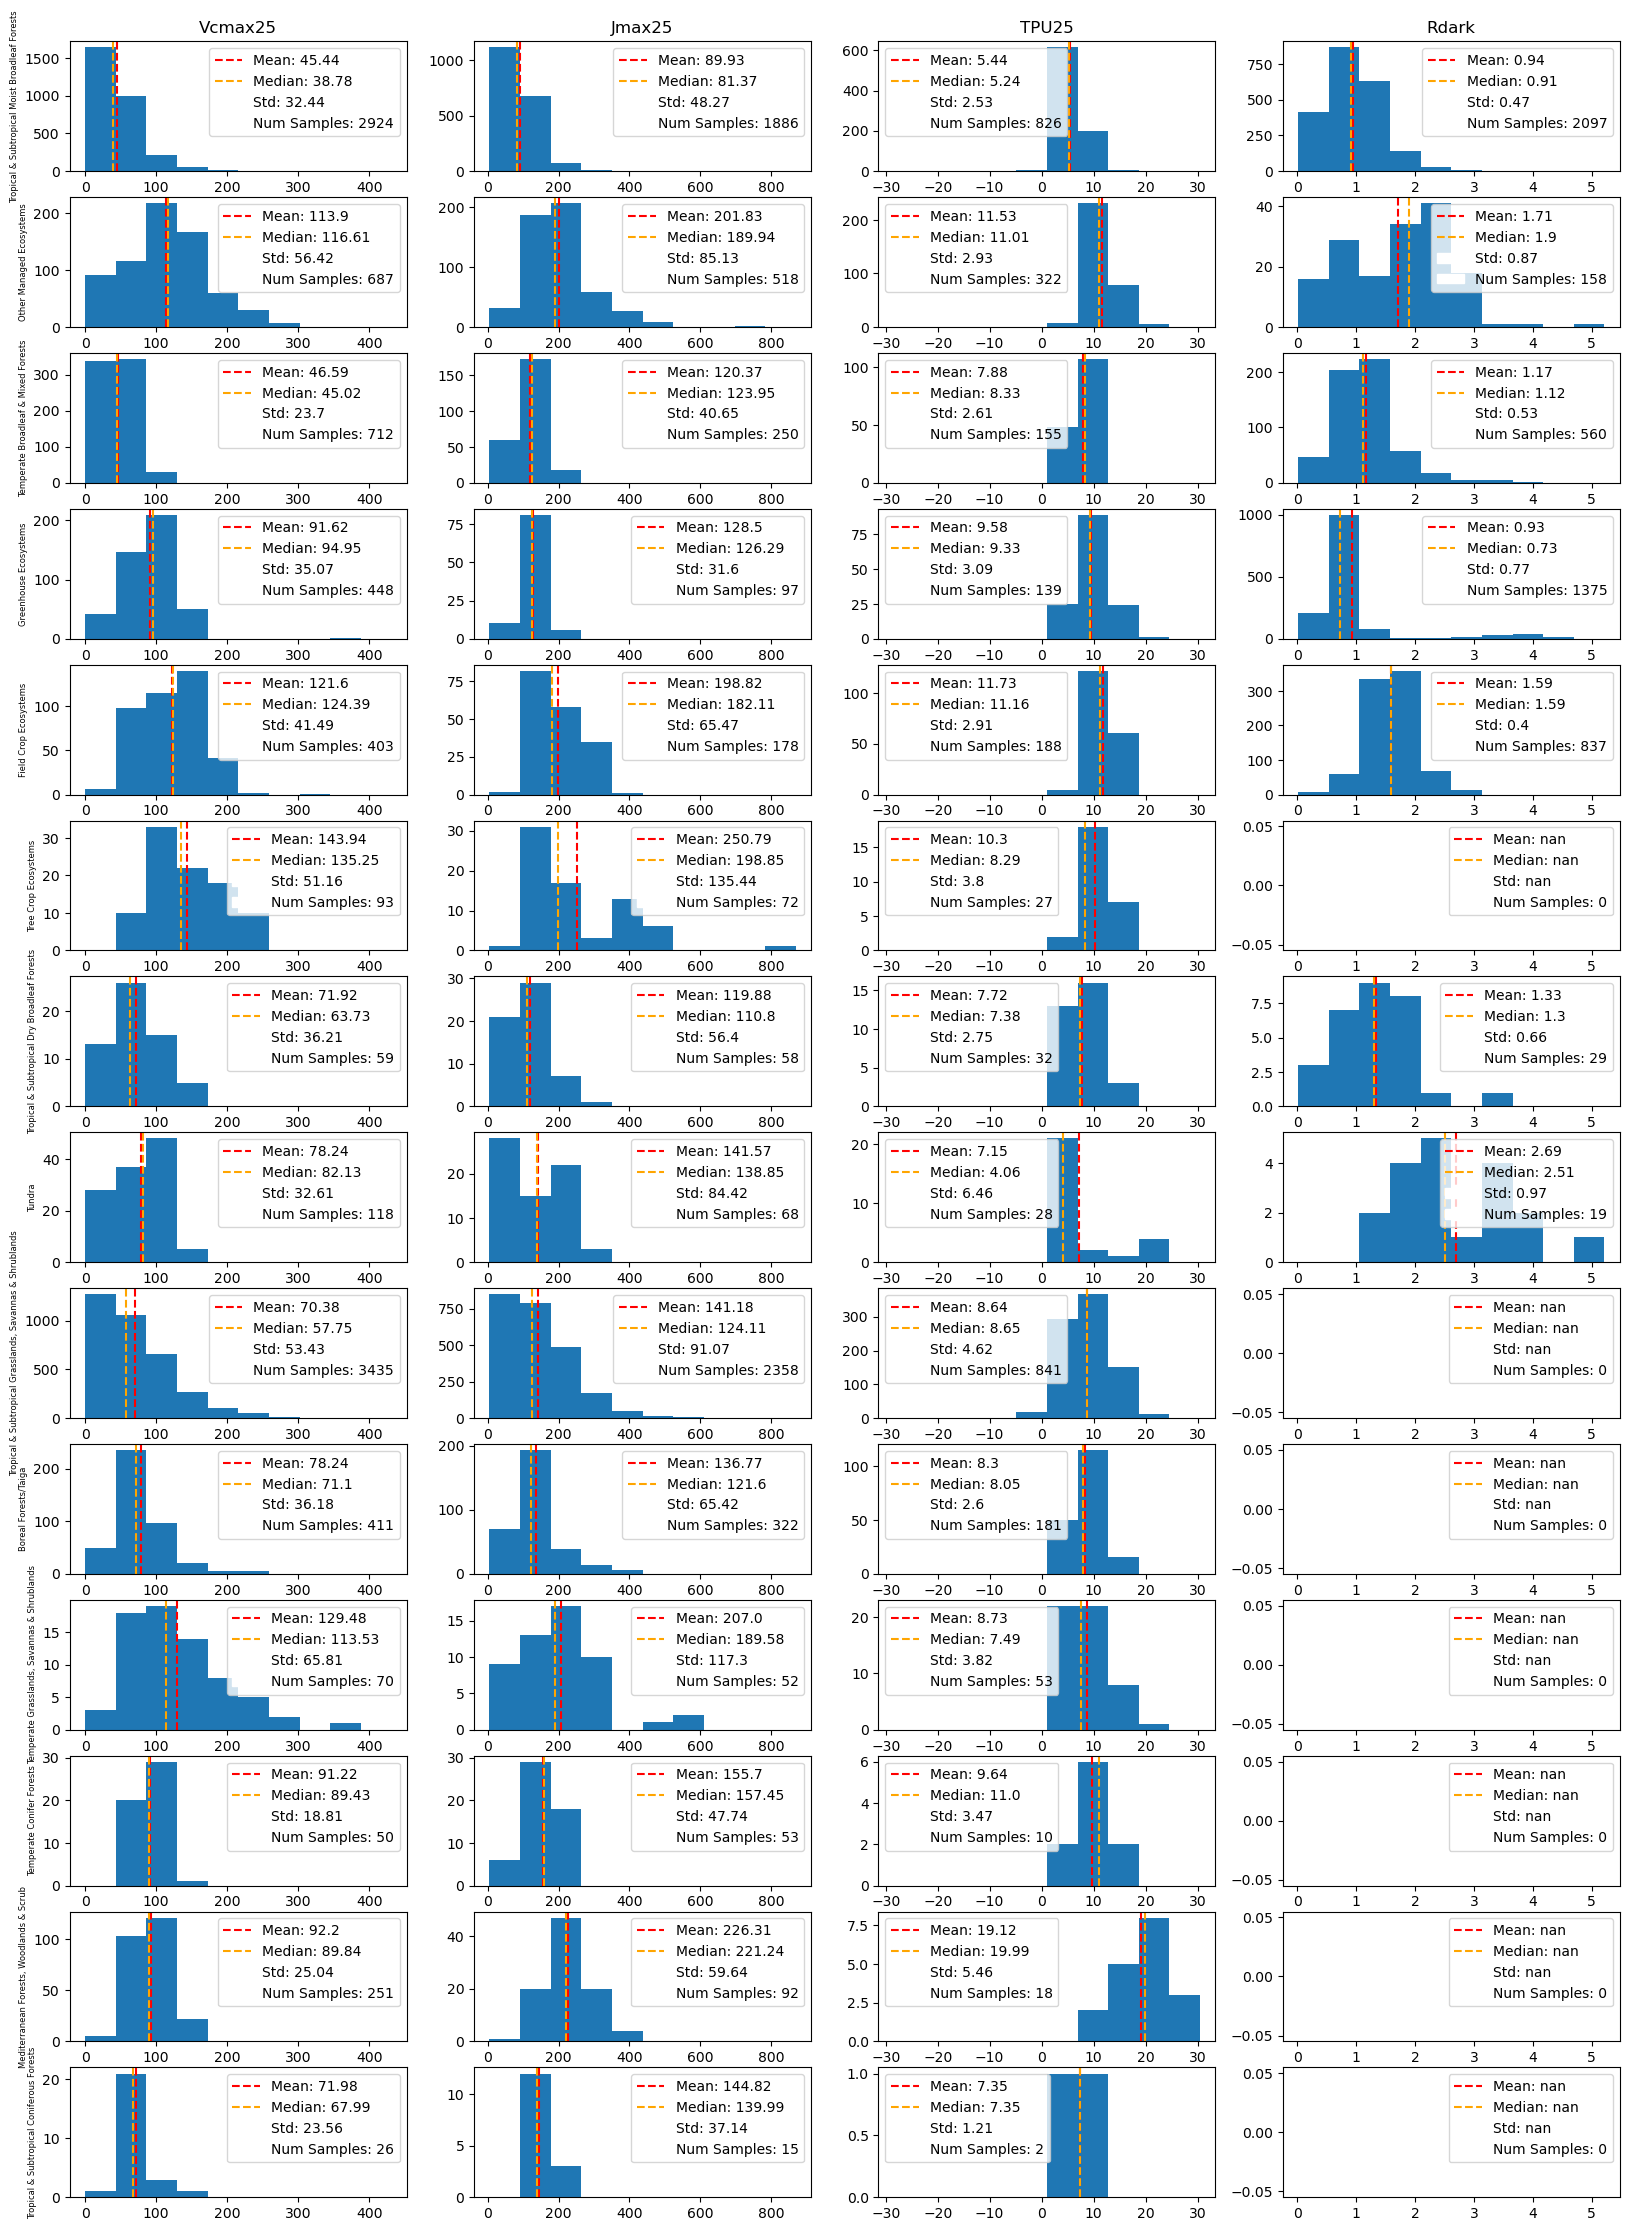

In [116]:
figs,ax = plt.subplots(14,4, figsize=(20,28))

params = ['Vcmax25','Jmax25','TPU25','Rdark']
biomes = database['Biome'].unique()

for i in range(len(biomes)):
    temp = database[database['Biome'] == biomes[i]]
    for j in range(len(params)):

        temp1 = temp.dropna(subset=[params[j]])
        ax[i,j].hist(temp1[params[j]], range=(np.nanmin(database[params[j]]), np.nanmax(database[params[j]])))

        mean = np.round(np.mean(temp1[params[j]]), decimals=2)
        median = np.round(np.median(temp1[params[j]]), decimals=2)
        std_dev = np.round(np.std(temp1[params[j]]), decimals=2)
        num_samples = len(temp1[params[j]])
        
        ax[i,j].axvline(mean, color='red', linestyle='dashed',label=f"Mean: {mean}")
        ax[i,j].axvline(median, color='orange', linestyle='dashed',label=f"Median: {median}")
        
        red_patch = mpatches.Patch(color='white', label= f"Std: {std_dev}")
        red_patch1 = mpatches.Patch(color='white', label= f"Num Samples: {num_samples}")
        
        handles, labels = ax[i,j].get_legend_handles_labels()
        handles.extend([red_patch,red_patch1])
        
        ax[i,j].legend(handles=handles)
        
        if i == 0:
            ax[i,j].set_title(params[j])
        if j == 0:
            ax[i,j].set_ylabel(biomes[i],fontsize=6)            
             
plt.show()

In [117]:
file = rasterio.open('/Users/rishi/Documents/ORNL Internships/25/Data/Spatial/koppen_geiger_tif/1991_2020/koppen_geiger_0p00833333.tif')
koppen_data = file.read(1)  
transform = file.transform

In [119]:
koppen_zone_major = []
koppen_zone_minor = []


for i in range(len(database)):
    row,col = file.index(database['Longitude'][i],database['Latitude'][i])
    
    koppen_zone_minor.append(koppen_data[row,col])
    
    if koppen_data[row,col] <= 3:
        koppen_zone_major.append(1)
    elif koppen_data[row,col] <= 7:
        koppen_zone_major.append(2)
    elif koppen_data[row,col] <= 16:
        koppen_zone_major.append(3)
    elif koppen_data[row,col] <= 28:
        koppen_zone_major.append(4)
    else:
        koppen_zone_major.append(5)


    
database['koppen_zone_major'] = koppen_zone_major
database['koppen_zone_minor'] = koppen_zone_minor

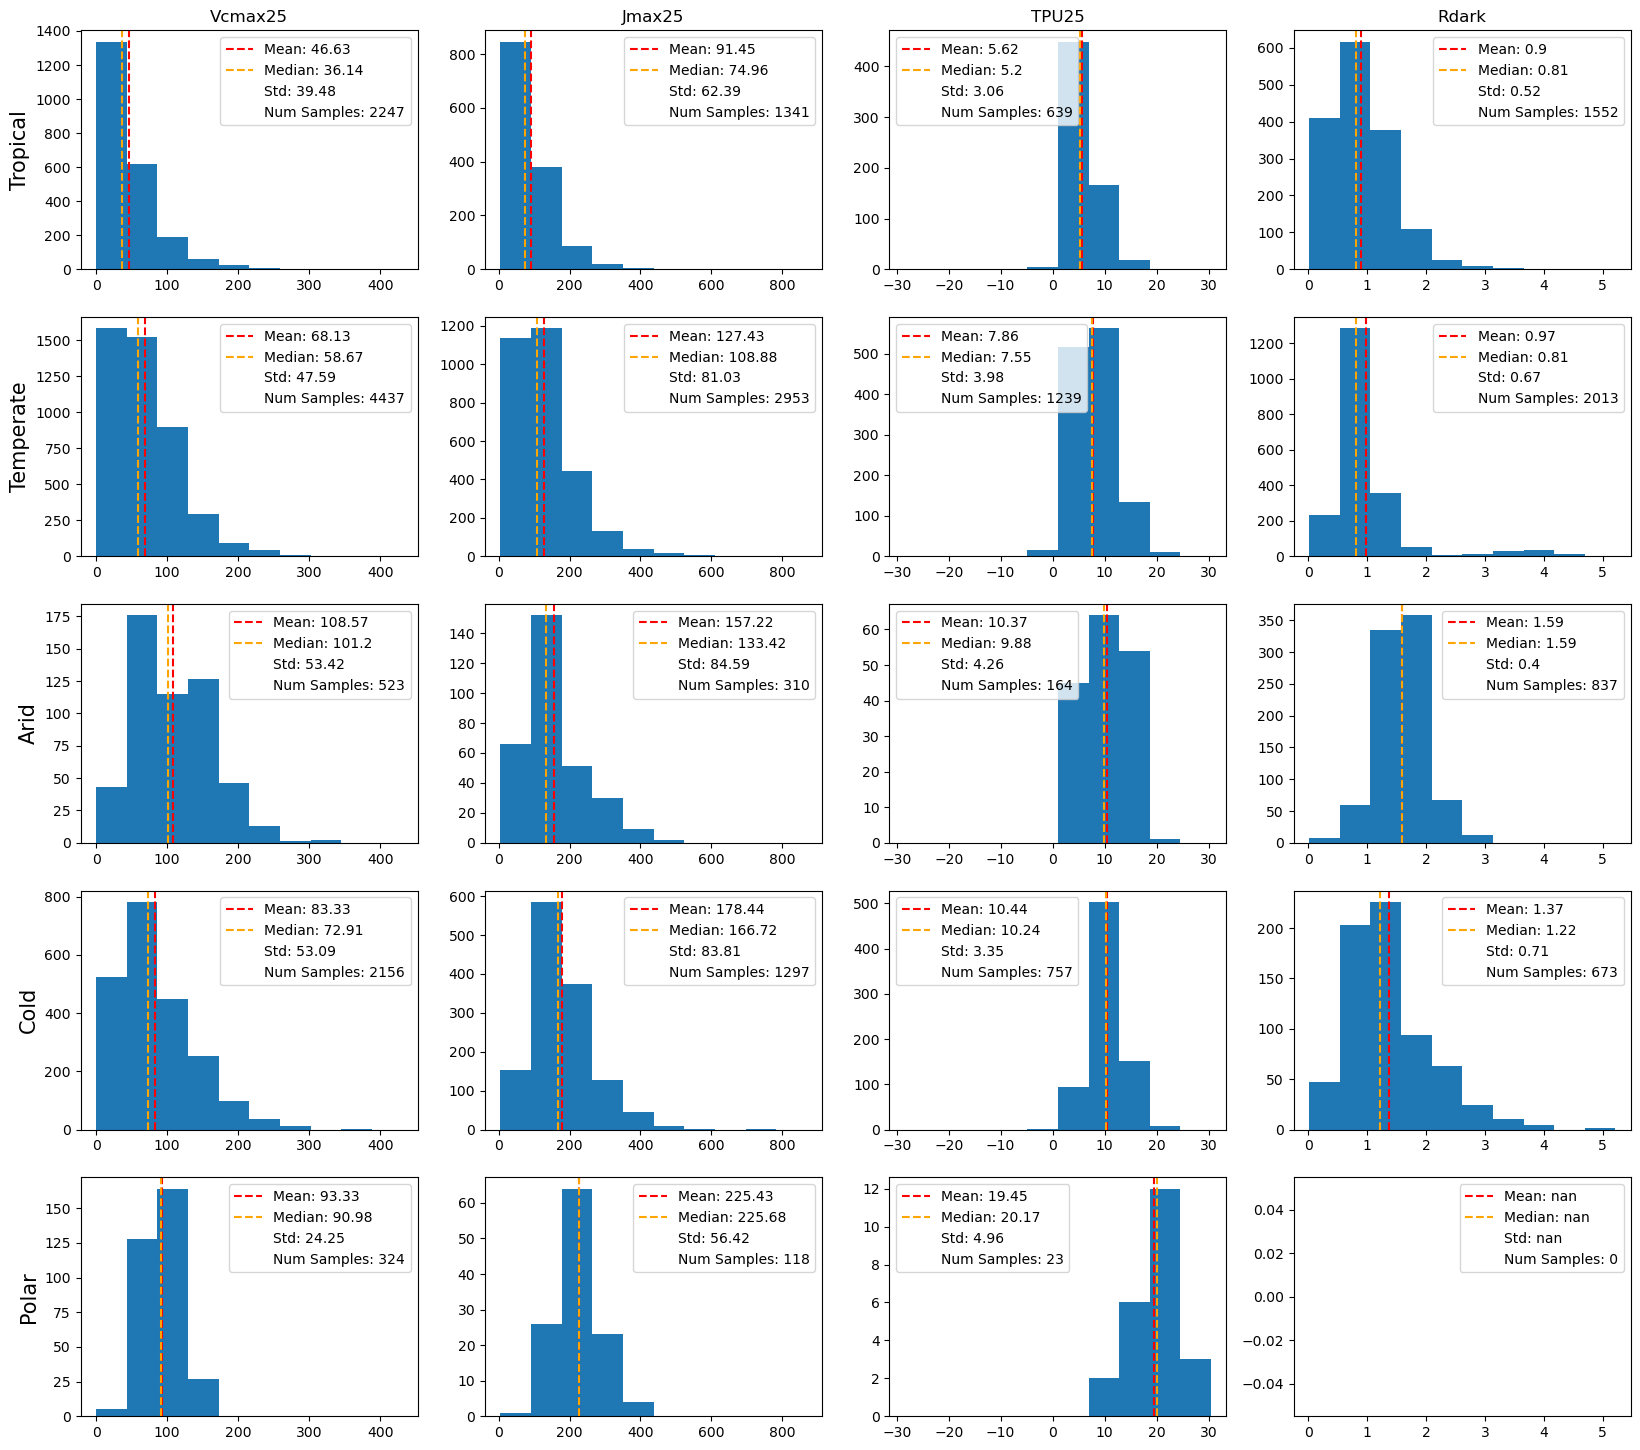

In [120]:
koppen_dict = {1:'Tropical',2:'Arid',3:'Temperate',4:'Cold',5:'Polar'}

figs,ax = plt.subplots(5,4, figsize=(20,18))

params = ['Vcmax25','Jmax25','TPU25','Rdark']
zones = database['koppen_zone_major'].unique()

for i in range(len(zones)):
    temp = database[database['koppen_zone_major'] == zones[i]]
    for j in range(len(params)):
        temp1 = temp.dropna(subset=[params[j]])
        ax[i,j].hist(temp1[params[j]], range=(np.nanmin(database[params[j]]), np.nanmax(database[params[j]])))
        
        mean = np.round(np.mean(temp1[params[j]]), decimals=2)
        median = np.round(np.median(temp1[params[j]]), decimals=2)
        std_dev = np.round(np.std(temp1[params[j]]), decimals=2)
        num_samples = len(temp1[params[j]])
        
        ax[i,j].axvline(mean, color='red', linestyle='dashed',label=f"Mean: {mean}")
        ax[i,j].axvline(median, color='orange', linestyle='dashed',label=f"Median: {median}")
        
        red_patch = mpatches.Patch(color='white', label= f"Std: {std_dev}")
        red_patch1 = mpatches.Patch(color='white', label= f"Num Samples: {num_samples}")
        
        handles, labels = ax[i,j].get_legend_handles_labels()
        handles.extend([red_patch,red_patch1])
        
        ax[i,j].legend(handles=handles)
        
        if i == 0:
            ax[i,j].set_title(params[j])
        if j == 0:
            ax[i,j].set_ylabel(koppen_dict[zones[i]],fontsize=15)          
        
plt.show()

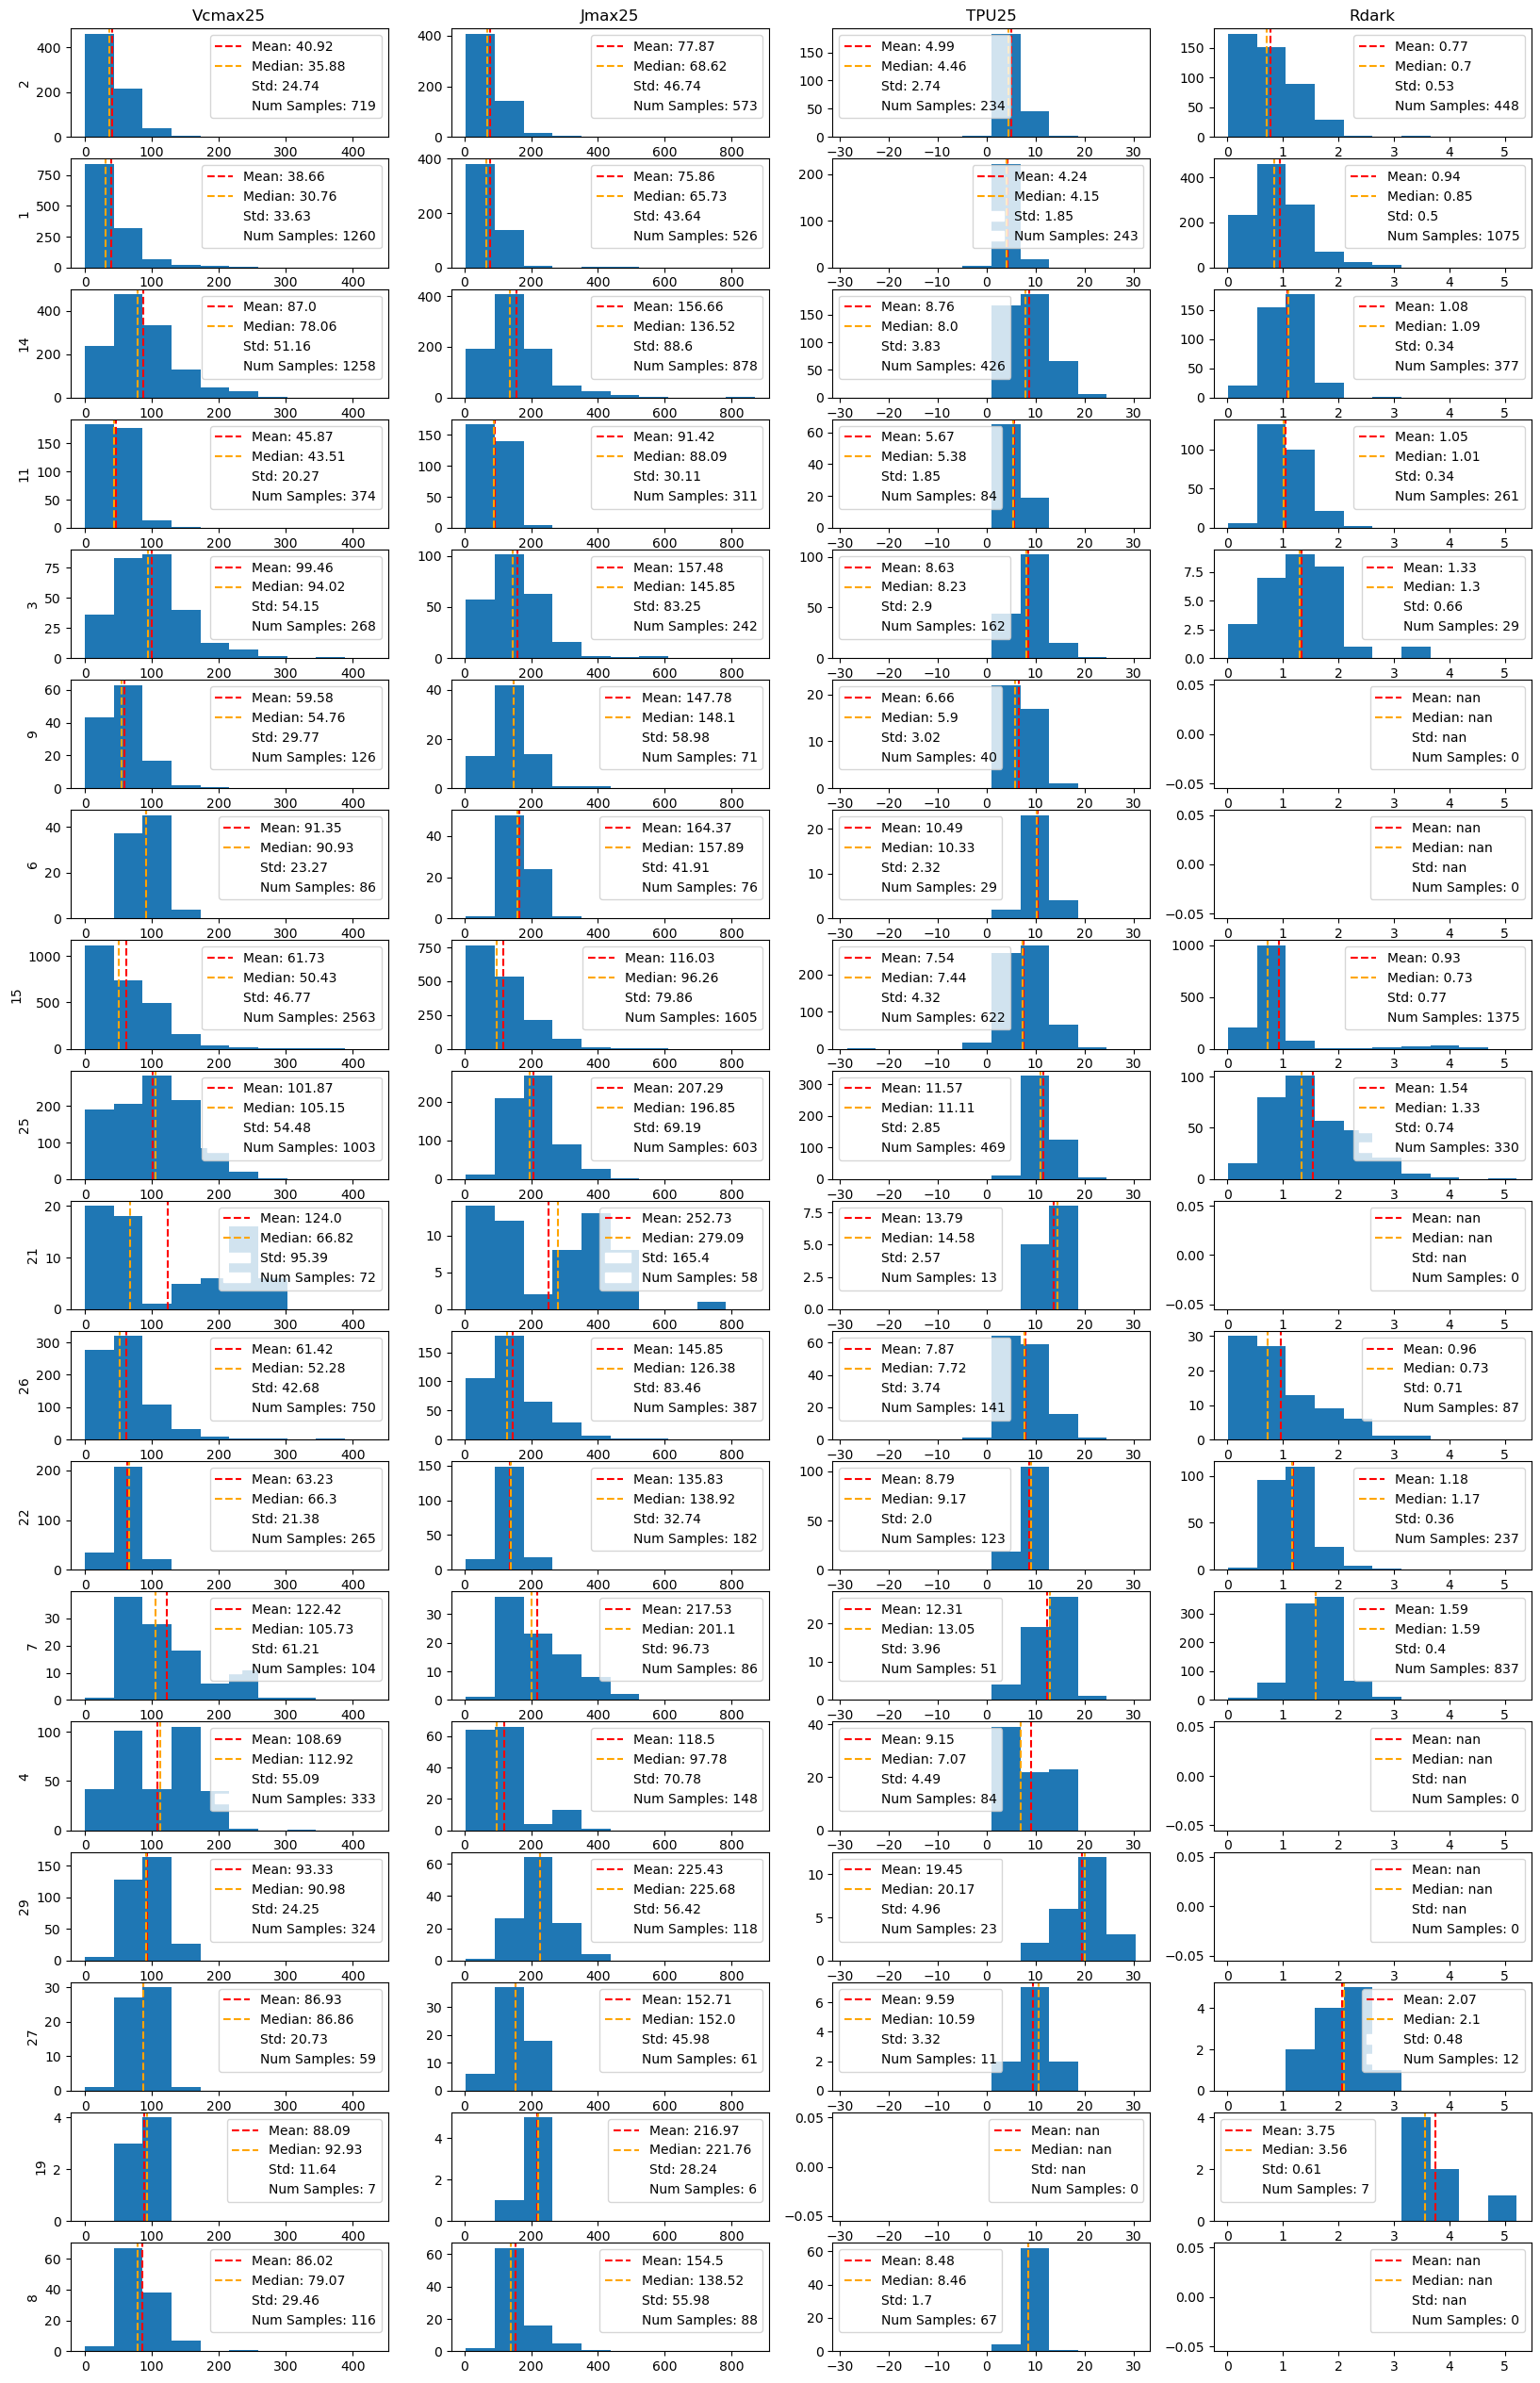

In [127]:
figs,ax = plt.subplots(18,4, figsize=(20,32))

params = ['Vcmax25','Jmax25','TPU25','Rdark']
zones = database['koppen_zone_minor'].unique()

for i in range(len(zones)):
    temp = database[database['koppen_zone_minor'] == zones[i]]
    for j in range(len(params)):
        temp1 = temp.dropna(subset=[params[j]])
        ax[i,j].hist(temp1[params[j]], range=(np.nanmin(database[params[j]]), np.nanmax(database[params[j]]))) 

        mean = np.round(np.mean(temp1[params[j]]), decimals=2)
        median = np.round(np.median(temp1[params[j]]), decimals=2)
        std_dev = np.round(np.std(temp1[params[j]]), decimals=2)
        num_samples = len(temp1[params[j]])
        
        ax[i,j].axvline(mean, color='red', linestyle='dashed',label=f"Mean: {mean}")
        ax[i,j].axvline(median, color='orange', linestyle='dashed',label=f"Median: {median}")
        
        red_patch = mpatches.Patch(color='white', label= f"Std: {std_dev}")
        red_patch1 = mpatches.Patch(color='white', label= f"Num Samples: {num_samples}")
        
        handles, labels = ax[i,j].get_legend_handles_labels()
        handles.extend([red_patch,red_patch1])
        
        ax[i,j].legend(handles=handles)
        
        if i == 0:
            ax[i,j].set_title(params[j])
        if j == 0:
            ax[i,j].set_ylabel(zones[i],fontsize=10)         
        
plt.show()

In [8]:
year = []
for i in range(len(database)):
    
    if database['Dataset_name'][i][-4:] == '21_2':
        year.append("2021")
    else:
        year.append(database['Dataset_name'][i][-4:])
database['year'] = year
database['year'].unique()

array(['2018', '2021', '2024', '2022', '2019', '2017', '2023', '2025',
       '2020'], dtype=object)

In [ ]:
for i in database['Latitude'].unique():
    temp = database[database['Latitude'] == i].reset_index()
    print((temp['Latitude'][0], temp['Longitude'][0]))
    

In [9]:
pft_data = pd.read_csv("/Users/rishi/Documents/ORNL Internships/25/PFT-Data-MCD12Q1-061-results.csv")
pft_data['year'] = pft_data['Date'].str[0:4]

In [10]:
max_pft = []
lat = []

for i in pft_data['Latitude'].unique():
    lat.append(i)
    
    temp = pft_data[pft_data['Latitude'] == i].reset_index()
    
    
    num_each = [0] * 16
    
    
    for j in range(len(temp)):
        num_each[int(temp['MCD12Q1_061_LC_Type5'][j])] += 1
        
    max_pft.append((np.argmax(num_each)))
    
    
lat_max_pft = pd.DataFrame({'max_pft':max_pft,'Latitude':lat})


In [11]:
database = database.merge(lat_max_pft,how='left',on='Latitude')

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


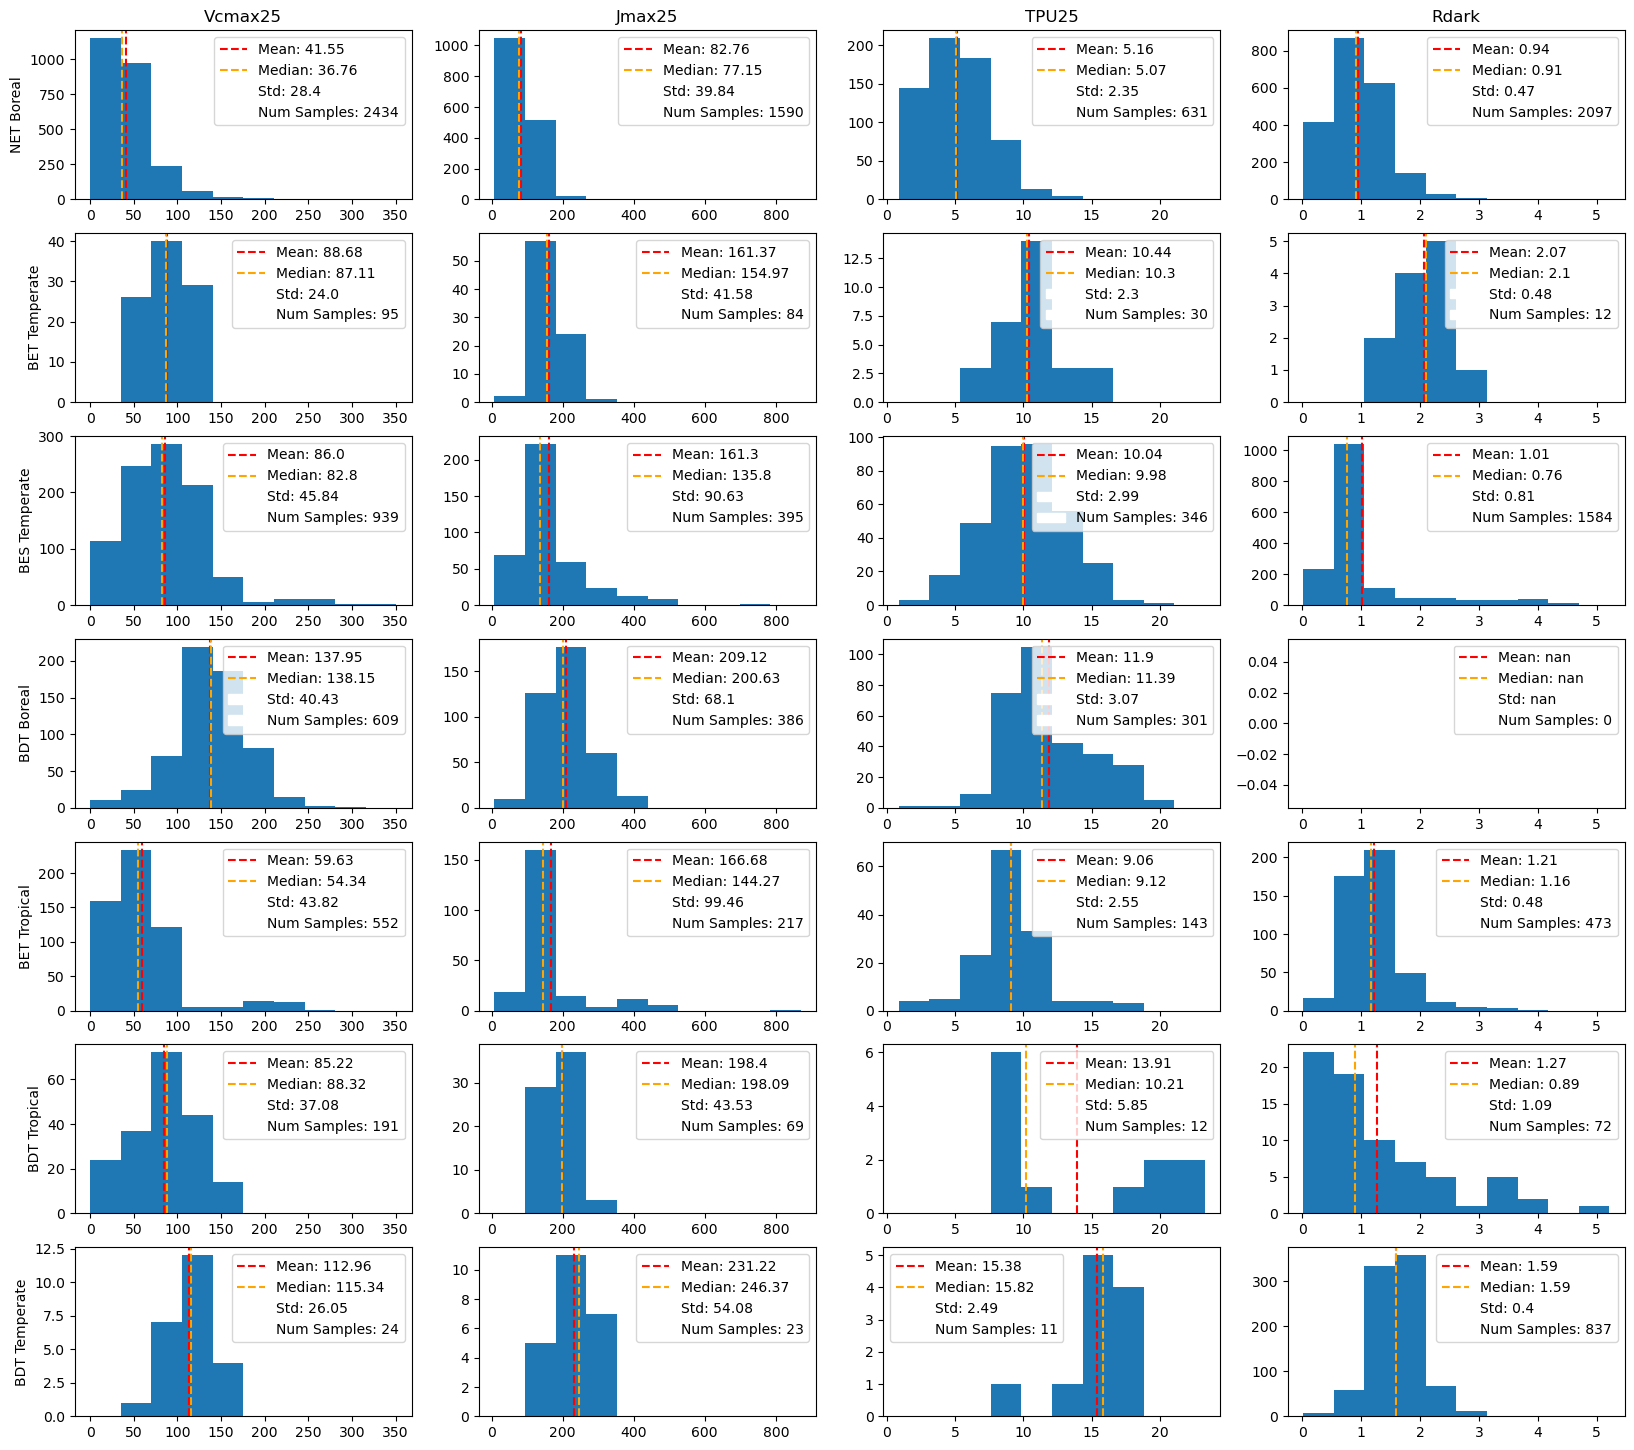

In [21]:
pft_dict = {2:'NET Boreal',3:'NDT Boreal',4:'BET Tropical',5:'BET Temperate',6:'BDT Tropical',7:'BDT Temperate',8:'BDT Boreal',9:'BES Temperate'}

figs,ax = plt.subplots(7,4, figsize=(20,18))

params = ['Vcmax25','Jmax25','TPU25','Rdark']
pfts = database['max_pft'].unique()

for i in range(len(pfts)):
    temp = database[database['max_pft'] == pfts[i]]
    
    for j in range(len(params)):
        temp1 = temp.dropna(subset=[params[j]])        
        ax[i,j].hist(temp1[params[j]], range=(np.nanmin(database[params[j]]), np.nanmax(database[params[j]])))
        
        mean = np.round(np.mean(temp1[params[j]]), decimals=2)
        median = np.round(np.median(temp1[params[j]]), decimals=2)
        std_dev = np.round(np.std(temp1[params[j]]), decimals=2)
        num_samples = len(temp1[params[j]])
        
        ax[i,j].axvline(mean, color='red', linestyle='dashed',label=f"Mean: {mean}")
        ax[i,j].axvline(median, color='orange', linestyle='dashed',label=f"Median: {median}")
        
        red_patch = mpatches.Patch(color='white', label= f"Std: {std_dev}")
        red_patch1 = mpatches.Patch(color='white', label= f"Num Samples: {num_samples}")
        
        handles, labels = ax[i,j].get_legend_handles_labels()
        handles.extend([red_patch,red_patch1])
        
        ax[i,j].legend(handles=handles)

        if i == 0:
            ax[i,j].set_title(params[j])
        if j == 0:
            ax[i,j].set_ylabel(pft_dict[pfts[i]],fontsize=10)
        
plt.show()

In [14]:
# Species Analysis

Text(0.5, 0, 'Num Species')

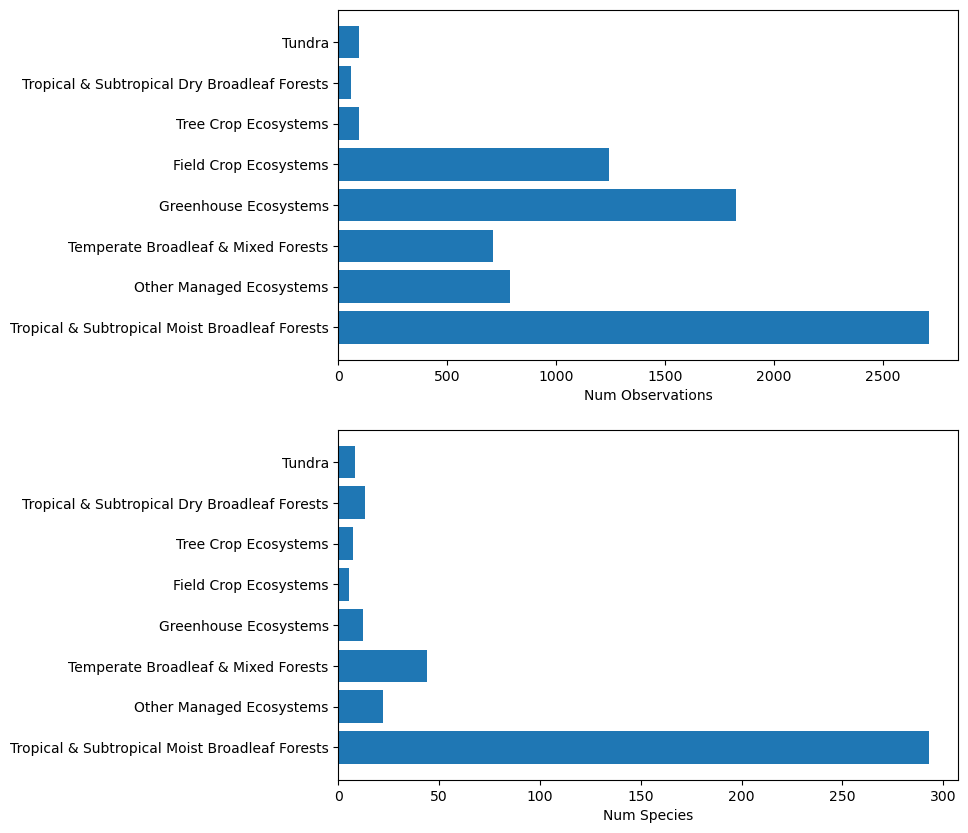

In [16]:
figs,ax = plt.subplots(2,1,figsize=(8,10))



num_species = []
num_observations = []
biome_name = []

for i in database['Biome_number'].unique():
    temp = database[database['Biome_number'] == i].reset_index()
    
    biome_name.append(temp['Biome'][0])
    num_observations.append(len(temp))
    num_species.append(len(temp['Species'].unique()))
    
ax[0].barh(biome_name,num_observations)
ax[0].set_xlabel("Num Observations")


ax[1].barh(biome_name,num_species)
ax[1].set_xlabel("Num Species")

Text(0.5, 0, 'Num Species')

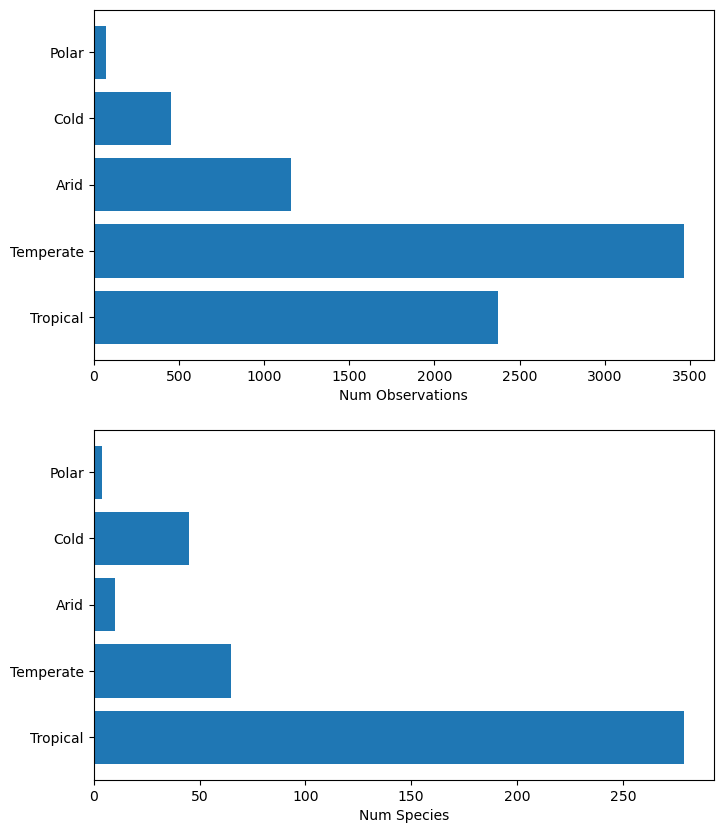

In [20]:
koppen_dict = {1:'Tropical',2:'Arid',3:'Temperate',4:'Cold',5:'Polar'}
figs,ax = plt.subplots(2,1,figsize=(8,10))



num_species = []
num_observations = []
koppen_zone_major_name = []

for i in database['koppen_zone_major'].unique():
    temp = database[database['koppen_zone_major'] == i].reset_index()
    
    koppen_zone_major_name.append(koppen_dict[temp['koppen_zone_major'][0]])
    num_observations.append(len(temp))
    num_species.append(len(temp['Species'].unique()))
    
ax[0].barh(koppen_zone_major_name,num_observations)
ax[0].set_xlabel("Num Observations")

ax[1].barh(koppen_zone_major_name,num_species)
ax[1].set_xlabel("Num Species")

<BarContainer object of 12 artists>

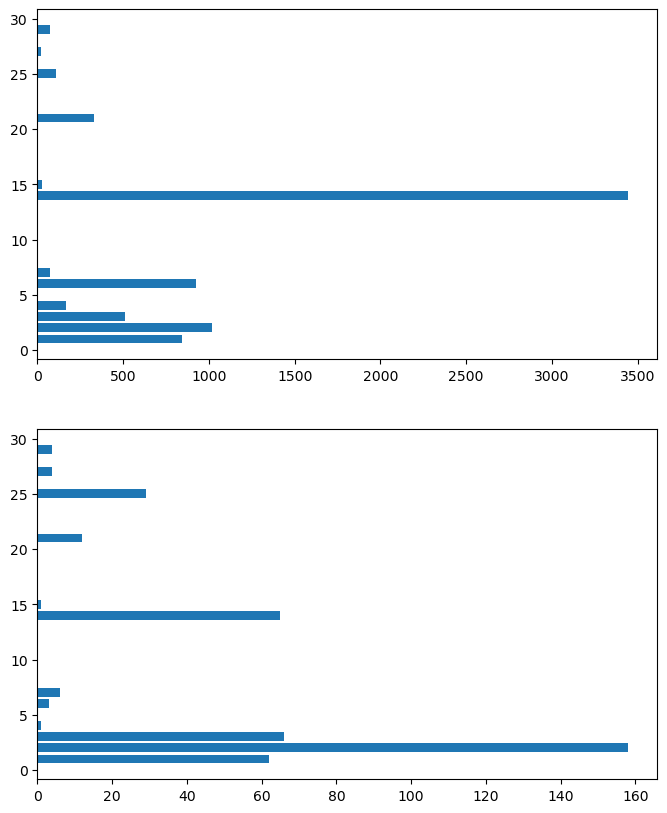

In [266]:
figs,ax = plt.subplots(2,1,figsize=(8,10))

num_species = []
num_observations = []
koppen_zone_minor_name = []

for i in database['koppen_zone_minor'].unique():
    temp = database[database['koppen_zone_minor'] == i].reset_index()
    
    koppen_zone_minor_name.append(temp['koppen_zone_minor'][0])
    num_observations.append(len(temp))
    num_species.append(len(temp['Species'].unique()))
    
ax[0].barh(koppen_zone_minor_name,num_observations)

ax[1].barh(koppen_zone_minor_name,num_species)

Text(0.5, 0, 'Num Species')

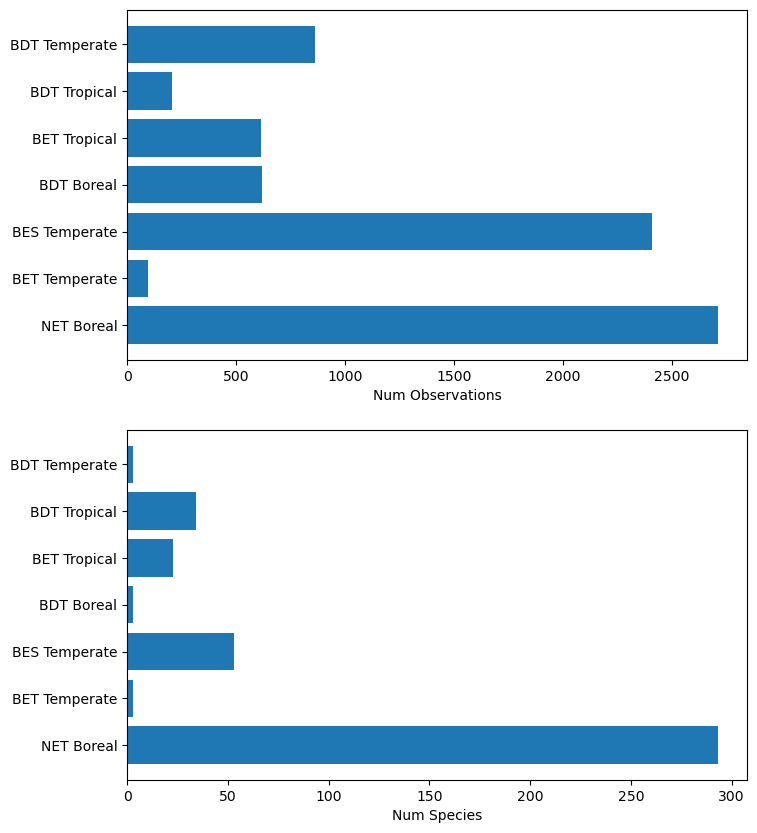

In [22]:
pft_dict = {2:'NET Boreal',3:'NDT Boreal',4:'BET Tropical',5:'BET Temperate',6:'BDT Tropical',7:'BDT Temperate',8:'BDT Boreal',9:'BES Temperate'}
figs,ax = plt.subplots(2,1,figsize=(8,10))

num_species = []
num_observations = []
pft_name = []

for i in database['max_pft'].unique():
    temp = database[database['max_pft'] == i].reset_index()
    
    pft_name.append(pft_dict[temp['max_pft'][0]])
    num_observations.append(len(temp))
    num_species.append(len(temp['Species'].unique()))
    
ax[0].barh(pft_name,num_observations)
ax[0].set_xlabel("Num Observations")

ax[1].barh(pft_name,num_species)
ax[1].set_xlabel("Num Species")

In [268]:
temp1 = database[database['Sun_Shade'] == np.nan]
temp1

,Site_name,SampleID,Dataset_name,Species,Sun_Shade,Phenological_stage,Plant_type,Photosynthetic_pathway,Soil,LMA,...,Wave_ 2496,Wave_ 2497,Wave_ 2498,Wave_ 2499,Wave_ 2500,Biome,koppen_zone_major,koppen_zone_minor,year,max_pft
